<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/037_Gradient_Boosting_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Gradient Boosting (XGBoost): Król Danych Tabelarycznych

Wyobraź sobie, że grasz w golfa.
1.  **Random Forest:** 100 graczy uderza piłkę niezależnie. Liczymy średnią pozycję piłek.
2.  **Gradient Boosting:**
    *   Gracz 1 uderza piłkę. Ląduje ona 20 metrów od dołka.
    *   Gracz 2 nie celuje do dołka. Celuje tak, żeby przesunąć piłkę o te brakujące 20 metrów (naprawia błąd).
    *   Gracz 3 poprawia drobny błąd Gracza 2.

To jest **Boosting**. Model uczy się na **Resztach (Residuals)**, czyli błędach poprzedników.

Użyjemy **XGBoost** (eXtreme Gradient Boosting) - biblioteki, która zoptymalizowała ten proces do granic możliwości.

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# 1. DANE (Ceny domów w Kalifornii)
# To duży zbiór z lat 90. ok 20k wierszy.
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Podział
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dane gotowe. Trening: {X_train.shape}")
display(X_train.head())

Dane gotowe. Trening: (16512, 8)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14196,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03
8267,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16
17445,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48
14265,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11
2271,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80


## Runda 1: Random Forest (Punkt odniesienia)

Najpierw sprawdźmy, jak poradzi sobie klasyczny Las Losowy. To będzie nasza poprzeczka do przeskoczenia.

In [3]:
# Trenujemy Las Losowy
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predykcja
rf_pred = rf_model.predict(X_test)

# --- POPRAWKA ---
# Zamiast squared=False, liczymy zwykłe MSE i pierwiastkujemy
mse_rf = mean_squared_error(y_test, rf_pred)
rf_error = np.sqrt(mse_rf) # RMSE (Root Mean Squared Error)

print(f"🌲 Random Forest RMSE: {rf_error:.4f}")
print("(Im mniej, tym lepiej. RMSE to średni błąd w tysiącach dolarów).")

🌲 Random Forest RMSE: 0.5053
(Im mniej, tym lepiej. RMSE to średni błąd w tysiącach dolarów).


## Runda 2: XGBoost (eXtreme Gradient Boosting)

Teraz wchodzi waga ciężka.
XGBoost ma setki parametrów, ale najważniejsze to:
*   `n_estimators`: Ile drzew naprawczych? (np. 1000).
*   `learning_rate` (eta): Jak ostrożnie poprawiamy błędy? (Małe kroki = lepiej, ale wolniej).
*   `early_stopping_rounds`: **Super ważna funkcja.** Mówimy: *"Jeśli przez 10 drzew wynik się nie poprawia, przestań trenować"*. To chroni przed Overfittingiem.

In [4]:
# Konfiguracja modelu
# objective='reg:squarederror' oznacza, że robimy regresję
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    early_stopping_rounds=10,
    n_jobs=-1,
    random_state=42
)

# TRENING Z WALIDACJĄ
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Predykcja
xgb_pred = xgb_model.predict(X_test)

# --- POPRAWKA ---
mse_xgb = mean_squared_error(y_test, xgb_pred)
xgb_error = np.sqrt(mse_xgb)

print("-" * 30)
print(f"🌲 Random Forest RMSE: {rf_error:.4f}")
print(f"🚀 XGBoost RMSE:      {xgb_error:.4f}")

diff = (rf_error - xgb_error) / rf_error * 100
print(f"\nPoprawa o {diff:.2f}%!")

------------------------------
🌲 Random Forest RMSE: 0.5053
🚀 XGBoost RMSE:      0.4550

Poprawa o 9.96%!


## Co jest ważne dla modelu? (Feature Importance)

XGBoost ma wbudowaną funkcję do sprawdzania, które cechy były najczęściej używane do podejmowania decyzji.

<Figure size 1000x600 with 0 Axes>

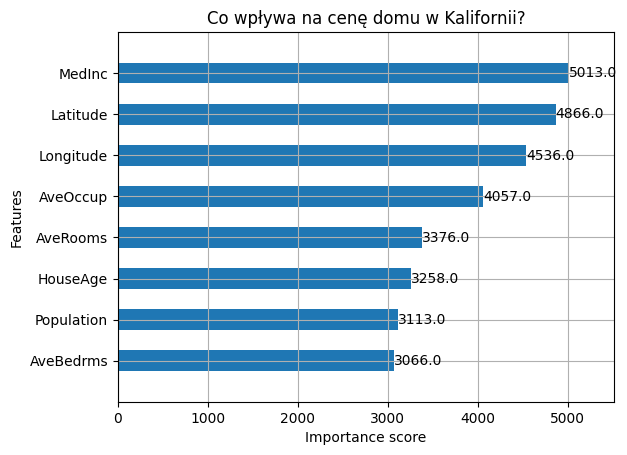

Analiza:
- MedInc (Median Income / Średni dochód): Zazwyczaj najważniejszy.
- OceanProximity: W tym zbiorze go nie ma (został zakodowany), ale lokalizacja to klucz.


In [5]:
# Rysujemy ważność cech
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, max_num_features=10, height=0.5)
plt.title("Co wpływa na cenę domu w Kalifornii?")
plt.show()

print("Analiza:")
print("- MedInc (Median Income / Średni dochód): Zazwyczaj najważniejszy.")
print("- OceanProximity: W tym zbiorze go nie ma (został zakodowany), ale lokalizacja to klucz.")

## 🧠 Podsumowanie: Bagging vs Boosting

Dlaczego XGBoost wygrał?

1.  **Random Forest (Bagging):**
    *   Buduje **duże, głębokie drzewa**. Każde drzewo uczy się mocno (i trochę overfittinguje), a na koniec uśredniamy wyniki, żeby zmniejszyć wariancję.
    *   *Zaleta:* Trudno go zepsuć, działa dobrze na domyślnych ustawieniach.

2.  **XGBoost (Boosting):**
    *   Buduje **małe, płytkie drzewka**.
    *   Każde drzewo skupia się **tylko na tych przypadkach, które poprzednie drzewa źle oceniły**.
    *   To tak, jakbyś uczył się do egzaminu, powtarzając tylko te pytania, na które źle odpowiedziałeś.
    *   *Zaleta:* Wyciąga z danych ostatnie soki.
    *   *Wada:* Łatwo o Overfitting, jeśli nie użyjesz `early_stopping` lub dasz za duże `learning_rate`.

**Wniosek:**
Masz tabelę Excela/CSV? Zacznij od XGBoost (lub jego braci: LightGBM, CatBoost). To obecnie state-of-the-art.